# Part 4: SCR Optimisation

This Part explores an optimisation algorithm to optimise for the SCR gradient UB parameter. The approach includes two constraints:
- upper bound on inc-sales reduction
- upper bound on inc-sales percentage reduction

In [76]:
import os, sys, importlib
import pandas as pd
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, '/home/jovyan/a01_repos')
import wx_tools.Wx_Utils as utl

sys.path.insert(0, '/home/jovyan/a01_repos/joe_utils')
import joe_utils.UDF_Visualisation as viz

# Project specific user-defined functions
import utl_scr_opt as udf
importlib.reload(sys.modules['utl_scr_opt'])

<module 'utl_scr_opt' from '/home/jovyan/a02_projects/a06_scr_optimisation/utl_scr_opt.py'>

In [77]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Data Prep

In [78]:
# Load data
scored_top2 = pd.read_parquet('data/scored_top2.parquet')
scored_top2.shape

cols = [
    'crn', 'offerId',
    'rank', 'score', 'inc_sales', 'target_cost',
    'scr', 'scr_gradient', 'inc_sales_diff', 'target_cost_diff',
]
scored_top2[cols].head(2)

(11208, 38)

crn  offerId  rank  score  inc_sales  target_cost  \
0  1000000000000000123       na     1   1.00   0.000000     0.000000   
1  1000000000000000123  -151044     2   0.95  -0.948526     0.089242   

         scr  scr_gradient  inc_sales_diff  target_cost_diff  
0        NaN           NaN        0.000000          0.000000  
1 -10.628664    -10.628664       -0.948526          0.089242

In [79]:
# Best offer
scored_best = pd.read_parquet('data/decision_model_999.parquet')

# Missing crns in best offer were assigned to random group
crn_missing = list(set(scored_top2['crn']) - set(scored_best['crn']))
len(crn_missing)

# View sample of misisng crns
cond = scored_top2['crn'].isin(crn_missing)
# scored_top2[cond].head()

# Analysis without missing crn
scored_top2 = scored_top2[~cond]
scored_top2.shape
scored_top2['crn'].nunique()

560

(10088, 38)

5044

## Scripting

In [80]:
base_metrics = scored_best[['inc_sales', 'target_cost']].sum()
base_metrics['profit'] = base_metrics[0] - base_metrics[1]
base_metrics['scr'] = base_metrics['inc_sales'] / base_metrics['target_cost']

cols = ['inc_sales', 'p_rdm', 'p_open', 'p_unsub']
base_constr_metrics = scored_best[cols].sum()

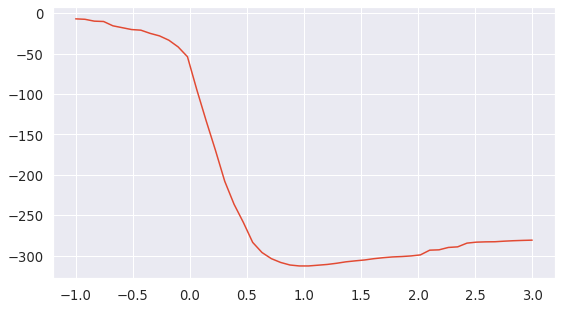

In [81]:
x = np.linspace(-1,3,50)
y = udf.obj_func(x, scored_top2, base_metrics)
plt.plot(x,y)

In [84]:
cols = ['rank', 'inc_sales', 'target_cost', 'score', 'scr_gradient', 'target_cost_diff']
scored_top2[cols].groupby('rank').sum()

inc_sales  target_cost        score  scr_gradient  target_cost_diff
rank                                                                       
1     7075.269043  2171.442383  4981.025782           0.0          0.000000
2     4736.730469  2139.774170  4812.992254           NaN        -31.668316

In [13]:
base_constr_metrics[0]

7075.2812

In [59]:
# Project specific user-defined functions
import utl_scr_opt as udf
importlib.reload(sys.modules['utl_scr_opt'])

<module 'utl_scr_opt' from '/home/jovyan/a02_projects/a06_scr_optimisation/utl_scr_opt.py'>

In [68]:
base_constr_metrics

inc_sales    7075.281250
p_rdm         419.399200
p_open       1995.038330
p_unsub         1.534759
dtype: float32

In [69]:
constr_ub

[inf, 2, 2, 1]

In [74]:
cols = ['crn', 'offerId', 'rank', 'inc_sales', 'target_cost', 'score',
       'scr_gradient', 'target_cost_diff', 'p_rdm', 'p_open', 'p_unsub']
top2 = scored_top2[cols]

In [75]:
# COBYLA (Constrained optimisation by linear approximation)
x0 = 0.5
constr_ub = [np.inf, 2, 2, 1]

x_opt = optimize.fmin_cobyla(udf.obj_func, x0, udf.constr_ineq,
                             args=(scored_top2, base_metrics),
                             consargs=(top2, base_constr_metrics, constr_ub))
type(x_opt)
x_opt

numpy.ndarray

array(0.08979446)

In [6]:
# COBYLA (Constrained optimisation by linear approximation)
# Optimise
x0 = 0.5
ub_c1= np.inf #100
ub_c2= np.inf #2.0
   
x_opt = optimize.fmin_cobyla(udf.obj_func, x0, udf.constr_ineq,
                             args=(scored_top2, base_metrics),
                             consargs=(scored_top2, base_metrics, ub_c1, ub_c2))
type(x_opt)
x_opt

numpy.ndarray

array(0.99804688)

In [67]:
# Reporting metrics at x_opt
y_opt_rpt = udf.obj_func(x_opt, scored_top2, base_metrics, 'rpt')
y_opt_rpt

SyntaxError: positional argument follows keyword argument (<ipython-input-67-7f2de58e33fa>, line 2)

In [120]:
InteractiveShell.ast_node_interactivity = "all"

## Visualise

In [259]:
n = 50
scr_gradient_ub_ls = np.linspace(-0.25, 3.5, n)

info_cols = ['scr_gradient_ub', 'crn', 'rank']
metric_cols = ['inc_sales', 'target_cost']
enum_cols = info_cols + metric_cols

df_enum = pd.DataFrame(columns=enum_cols)

for ub in scr_gradient_ub_ls:
    scored_sel = udf.choose_offer(scored_top2, ub)
    scored_sel['scr_gradient_ub'] = ub
    df_enum = pd.concat((df_enum, scored_sel[enum_cols]), axis=0)

In [302]:
# Get total
df_enum_total = df_enum.groupby(['scr_gradient_ub'])[metric_cols].sum().reset_index()

# Get baseline total inc-sales and cost
scored_best_total = scored_best[metric_cols].sum()

# SCR
df_enum_total['scr'] = df_enum_total['inc_sales'] / df_enum_total['target_cost']
scored_best_total['scr'] = scored_best_total['inc_sales'] / scored_best_total['target_cost']

# Net revenue
df_enum_total['net_revenue'] = df_enum_total['inc_sales'] - df_enum_total['target_cost'] 

# Delta
df_enum_total['inc_sales_delta'] = df_enum_total['inc_sales'] - scored_best_total['inc_sales']
df_enum_total['target_cost_delta'] = df_enum_total['target_cost'] - scored_best_total['target_cost']
df_enum_total['net_revenue_gain'] = df_enum_total['inc_sales_delta'] - df_enum_total['target_cost_delta'] 

# Percentages
base_revenue = scored_best_total['inc_sales'] - scored_best_total['target_cost']
df_enum_total['inc_sales_delta_perc'] = df_enum_total['inc_sales_delta'] / scored_best_total['inc_sales'] * 100
df_enum_total['target_cost_delta_perc'] = df_enum_total['target_cost_delta'] / scored_best_total['target_cost'] * 100
df_enum_total['net_revenue_gain_perc'] = df_enum_total['net_revenue_gain'] / base_revenue * 100

In [261]:
df_enum_total.head(2)

scr_gradient_ub    inc_sales  target_cost       scr  inc_sales_delta  \
0        -0.250000  7088.293945  2153.240967  3.291919        13.012695   
1        -0.173469  7088.671387  2151.470947  3.294802        13.390137   

   target_cost_delta  net_revenue_gain  inc_sales_delta_perc  \
0         -18.197266         31.209961              0.183918   
1         -19.967285         33.357422              0.189252   

   target_cost_delta_perc  net_revenue_gain_perc  
0               -0.838028               0.636439  
1               -0.919542               0.680230

In [311]:
# Project specific user-defined functions
import utl_scr_opt as udf
importlib.reload(sys.modules['utl_scr_opt'])

<module 'utl_scr_opt' from '/home/jovyan/a02_projects/a06_scr_optimisation/utl_scr_opt.py'>

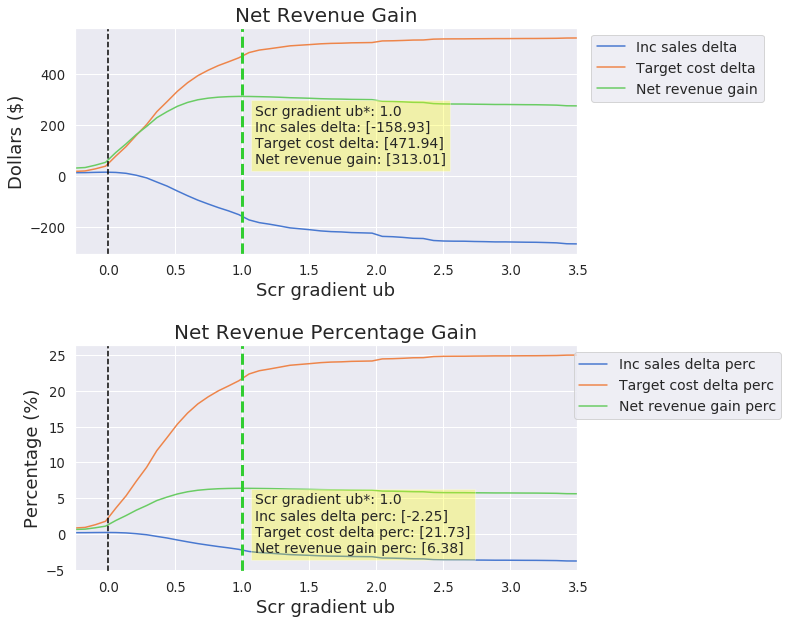

In [265]:
df_plot = df_enum_total.copy()
df_plot['target_cost_delta'] = -df_plot['target_cost_delta']
df_plot['target_cost_delta_perc'] = -df_plot['target_cost_delta_perc']

fig, ax = plt.subplots(2,1, figsize=(9,10))
fig.subplots_adjust(hspace=0.4) # the amount of height reserved for white space between subplots # 0.2

# Net Revenue
y_opt = list(y_opt_rpt.values())[:3]
f=udf.plot_multi_metrics(df_plot, x='scr_gradient_ub',
                         metric_ls=['inc_sales_delta', 'target_cost_delta', 'net_revenue_gain'],
                         title='Net Revenue Gain', ylabel='Dollars ($)',
                         x_opt=x_opt, y_opt=y_opt, text_y_pos=y_opt_rpt.get('net_gain'),
                         fig=fig, ax=ax[0])
# Percentage Revenue
f=udf.plot_multi_metrics(df_plot, x='scr_gradient_ub',
                         metric_ls=['inc_sales_delta_perc', 'target_cost_delta_perc', 'net_revenue_gain_perc'],
                         title='Net Revenue Percentage Gain', ylabel='Percentage (%)',
                         x_opt=x_opt, y_opt=list(y_opt_rpt.values())[3:], text_y_pos=y_opt_rpt.get('net_gain_perc'),
                         fig=fig, ax=ax[1])

Text(1.5, 3.26, 'Base SCR: 3.26')

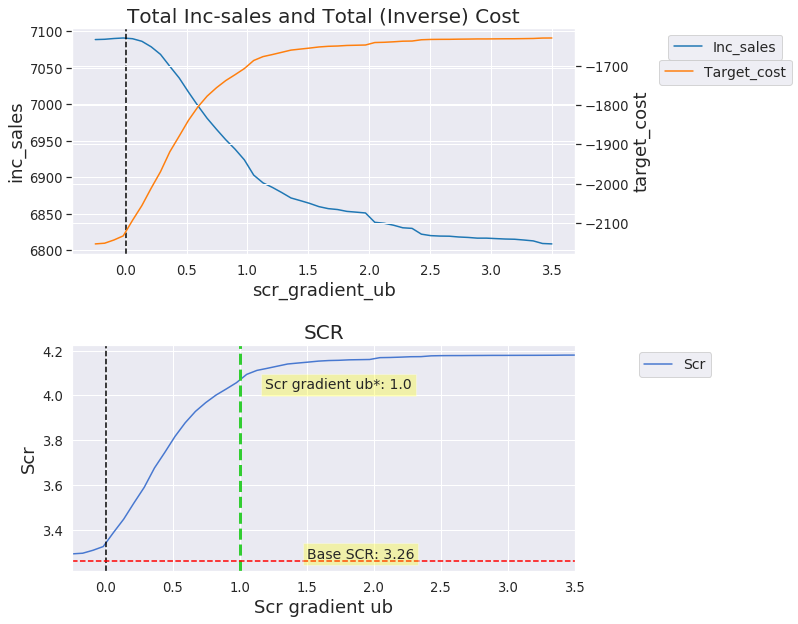

In [313]:
# inc-sales vs cost
df_plot = df_enum_total.copy()
df_plot['target_cost'] = -df_plot['target_cost']

fig, ax = plt.subplots(2,1, figsize=(9,10))
fig.subplots_adjust(hspace=0.4) # the amount of height reserved for white space between subplots # 0.2

# inc-sales and cost
f=udf.plot_dual_metrics(df_plot, x='scr_gradient_ub', y1='inc_sales', y2='target_cost',
                      title='Total Inc-sales and Total (Inverse) Cost',
                      fig=fig, ax=ax[0],
                      x_opt=None, text_opt=None, text_y_pos=None)
# SCR
f2, ax2 = udf.plot_multi_metrics(df_plot, x='scr_gradient_ub', metric_ls=['scr'],
                         title='SCR', x_opt=x_opt, fig=fig, ax=ax[1])

base_scr = base_metrics['scr'].round(2)
ax2.plot([-0.25, 3.5], [base_scr, base_scr], 'r--')
ax2.text(1.5, base_scr, s=f'Base SCR: {base_scr}', fontsize=14, verticalalignment='bottom',
                 bbox=dict(facecolor='yellow', alpha=0.3))

In [314]:
base_metrics

inc_sales      7075.281250
target_cost    2171.438232
net_revenue    4903.842773
scr               3.258339
dtype: float64

Text(1.5, 4903, 'Base net revenue: $4903')

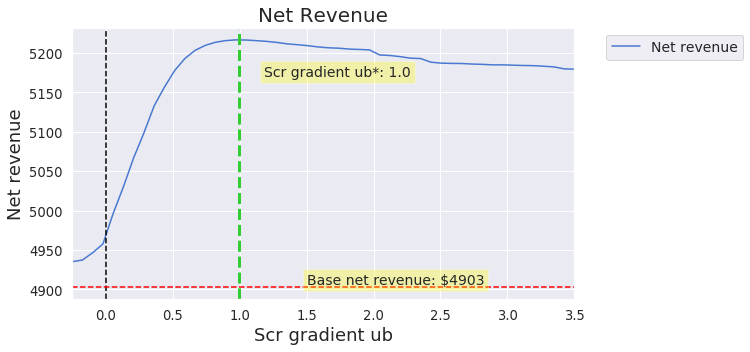

In [319]:
df_plot = df_enum_total.copy()
f,ax=udf.plot_multi_metrics(df_plot, x='scr_gradient_ub', metric_ls=['net_revenue'],
                         title='Net Revenue', x_opt=x_opt)

base_net_revenue = base_metrics['net_revenue'].astype('int')
ax.plot([-0.25, 3.5], [base_net_revenue, base_net_revenue], 'r--')
ax.text(1.5, base_net_revenue, s=f'Base net revenue: ${base_net_revenue}', fontsize=14, verticalalignment='bottom',
                 bbox=dict(facecolor='yellow', alpha=0.3))

## Appendix
Attempts at other optimisation methods.

- SLSQP is sensitive to "eps" (step size used for numerical approximation of the Jacobian) and converges slowly [scipy](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html)
- Couldn't get trust-constr to work

In [623]:
# trust-constr
x0 = 0.5
# ineq_cons = optimize.NonlinearConstraint(constr_ineq, lb=0, ub=np.inf)

ineq_cons = {'type': 'ineq',
             'fun' : udf.constr_ineq_2,
             'args': (scored_top2, base_metrics, ub_c1, ub_c2)}


res = optimize.minimize(udf.obj_func, x0, method='trust-constr', #method='slsqp',
                        args=(scored_top2, base_metrics),
                        constraints=ineq_cons,
                        options={'disp': True, 'gtol': 1e-10, 'xtol': 1e-10, 'initial_tr_radius': 3})

res
# optimize.show_options(solver='minimize', method='trust-constr')

`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 2, CG iterations: 0, optimality: 0.00e+00, constraint violation: 0.00e+00, execution time: 0.0017 s.


 barrier_parameter: 0.1
 barrier_tolerance: 0.1
          cg_niter: 0
      cg_stop_cond: 0
            constr: [array([1.2196093], dtype=float32)]
       constr_nfev: [2]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 0.0017290115356445312
               fun: array([-270.39954], dtype=float32)
              grad: array([0.])
               jac: [array([[0.]])]
   lagrangian_grad: array([0.])
           message: '`gtol` termination condition is satisfied.'
            method: 'tr_interior_point'
              nfev: 2
              nhev: 0
               nit: 1
             niter: 1
              njev: 0
        optimality: 0.0
            status: 1
           success: True
         tr_radius: 3
                 v: [array([-0.05466232])]
                 x: array([0.5])

In [625]:
# SLSQP
x0 = 0.5
ub_c1=100
ub_c2=2

ineq_cons_1 = {'type': 'ineq',
               'fun' : udf.constr_ineq,
               'args': (scored_top2, base_metrics, ub_c1, ub_c2)}
ineq_cons_2 = {'type': 'ineq',
               'fun' : udf.constr_ineq_2,
               'args': (scored_top2, base_metrics, ub_c1, ub_c2)}

# res = optimize.minimize(udf.obj_func, x0, method='SLSQP',
#                         constraints=[ineq_cons_1, ineq_cons_2],
#                         args=(scored_top2, base_metrics),
#                         options={'disp': True, 'ftol': 1e-5, 'eps': 1e-3, 'maxiter': 50})
# res

### Unconstrained optimisation

In [630]:
# Nelder-Mead
res = optimize.minimize(udf.obj_func, 0.5, args=(scored_top2, base_metrics), 
                        method='Nelder-Mead', tol=1e-5, options={'disp': True})
res.fun
res.x

Optimization terminated successfully.
         Current function value: -313.014038
         Iterations: 20
         Function evaluations: 47


-313.0140380859375

array([0.9984375])

In [627]:
# Powell
res = optimize.minimize(udf.obj_func, 0.5, args=(scored_top2, base_metrics),
                        method='powell', tol=1e-5, options={'disp': True})
res.x
res.fun

Optimization terminated successfully.
         Current function value: -313.014038
         Iterations: 2
         Function evaluations: 84


array(0.99784139)

array(-313.01404, dtype=float32)